In [290]:
import numpy as np
import time
from scipy.special import gammaln
import torch

import scipy.stats as stats
import train_2D_rt_v1 as tr
import tools_2D_rt_v1 as tt

import matplotlib.pyplot as plt

# Generate Data


Make sure you have also copied '/home/mcarilli/CME/2D_CME/learning_environment/train_2D_rt_v1.py' and
'/home/mcarilli/CME/2D_CME/learning_environment/tools_2D_rt_v1.py' to your file location. 


If you want to load in pre-generated data, there are 20 batches of 5,120 are already stored in:


1. '/home/mcarilli/CME/2D_CME/learning_environment/training_data_quadvec/'
2. '/home/mcarilli/CME/2D_CME/learning_environment/training_data_fixedquad/'


There are also 10 batches of 512 parameters in 1 (_fixedquad/_) and 10 batches of 256 parameterc in 2 (_quadvec/_). 
generated using quad_vec and fixed_quad, respectively. 


If you want to make and store other data files, here is some code:

In [83]:
# define your data path

path =  './training_data_quadvec/'

In [4]:
set_size = 256
num_files = 10
N = num_files*set_size


params = tr.generate_param_vectors(N)

In [ ]:
# define your xmax function!! 

def xmax_fun(xmax):

    return(4.5*xmax)

In [ ]:
#generate_sets(set_size,num_files,param_vectors,method,xmax_fun,NCOR,path_to_directory)
tr.generate_sets_pcme(set_size = 256,num_files=num_files,param_vectors = params,
                 method = 'quad_vec',
                 xmax_fun=xmax_fun,
                 NCOR = 60,
                 path_to_directory=path)

# Train ! 


Here are the generating grid and get_ypred_at_RT functions! 

In [302]:
def generate_grid(npdf,VAR,MU,quantiles=None):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas)
        translin_1 = torch.exp(logmean[1]+logstd[1]*NORM_mat)
        return translin_0,translin_1
        return(translin)
    
    
def generate_grid_3(npdf,VAR,MU,p,quantiles=None):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        
        # calculate sigma_ij
        var_ij = p[0]**2/ (p[1]+p[2]) 
        logst_ij = torch.log( var_ij * np.exp(-(MU[0]+MU[1]+0.5*VAR[0]+0.5*VAR[1])) + 1 )
        
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas+logst_ij*NORM_mat)
        translin_1 = torch.exp(logmean[0]+logstd[0]*NORM_mat+logst_ij*NORM_nas)
        
        return translin_0,translin_1
        return(translin)
    
def generate_grid_affine(npdf,VAR,MU,p,quantiles=None):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        
        # calculate sigma_ij
        var_ij = p[0]**2/ (p[1]+p[2]) 
        logst_ij = torch.log( var_ij * np.exp(-(MU[0]+MU[1]+0.5*VAR[0]+0.5*VAR[1])) + 1 )
        
        sig_ii = logstd[0]
        sig_jj = logstd[1]
        sig_ij = logst_ij
        
        
        xv, yv = torch.meshgrid(NORM_nas,NORM_mat,indexing='ij')
        
        GRID_nas = torch.exp(sig_ii*xv+sig_ij*yv + logmean[0])
        #print('grid_nas:', GRID_nas)
        GRID_mat = torch.exp(sig_ij*xv+sig_jj*yv + logmean[1])
        
        return(GRID_nas,GRID_mat)
    
def generate_grid_2(npdf,VAR,MU,l_out,quantiles=None):
    
    
    A,B,C,D = l_out
    
    
    norm_nas = A*NORM_nas + B*NORM_mat
    norm_mat = C*NORM_nas + D*NORM_mat
    
    #norm_nas = norm_nas/torch.sum(norm_nas)
    #norm_mat = norm_nas/torch.sum(norm_mat)
    #print('norm_nas:',norm_nas)
    #print('norm_mat:',norm_mat)
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas)
        translin_1 = torch.exp(logmean[1]+logstd[1]*NORM_mat)
        return translin_0,translin_1
        return(translin)


def get_ypred_at_RT_affine(p,npdf,w,hyp,l_out,quantiles='PRESET',
                   first_special=False,special_std='tail_prob'):
    p = 10**p
    MU, VAR, STD, xmax = tr.get_moments(p)
    
    GRID_nas,GRID_mat = generate_grid_affine(npdf,VAR,MU,p,quantiles=quantiles)

    
   
    s_nas = torch.zeros((GRID_nas.shape))
    s_mat =  torch.zeros((GRID_mat.shape))

    spec = 0 if first_special else -1
    if first_special:
        s_nas[1:,:] = torch.diff(GRID_nas,axis=0)
        s_mat[:,1:] = torch.diff(GRID_mat)
    else: #last special... for now
        s_nas[:-1,:] = torch.diff(GRID_nas,axis=0)
        s_mat[:,:-1] = torch.diff(GRID_mat)
    
    if special_std == 'mean':
        s_nas[spec] = GRID_nas[spec]
        s_mat[spec] = GRID_mat[spec]
    elif special_std == 'neighbor': #assign_neighbor_to_special
        s_nas[spec] = s_nas[1] if first_special else s_nas[-2]
        s_mat[spec] = s_mat[1] if first_special else s_mat[-2]
        
    elif special_std == 'tail_prob':
        if first_special:
            print('If you are using this setting, you are doing something wrong.')
        t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
        f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
        tailratio = 1/(1+1/f) #the mature tail ratio
        s_mat[:,spec] = torch.sqrt(GRID_mat[:,spec] / (1-tailratio))
        tailratio = p[0]/(1+p[0]) #the nascent tail ratio
        s_nas[spec,:] = torch.sqrt(GRID_nas[spec,:] / (1-tailratio))
    else:
        print('did not specify a standard deviation convention!')
    
    s_nas *= hyp
    s_mat *= hyp
    v_nas = s_nas**2
    v_mat = s_mat**2

    r_nas = GRID_nas**2/(v_nas-GRID_nas)
    p_nas = 1-GRID_nas/v_nas 
    r_mat = GRID_mat**2/(v_mat-GRID_mat)
    p_mat = 1-GRID_mat/v_mat 
    
    xgrid_nas = torch.arange(xmax[0]+1)
    xgrid_mat = torch.arange(xmax[1]+1)
    
    gammaln_xgrid_nas = lnfactorial[1:(xmax[0]+2)]
    gammaln_xgrid_mat = lnfactorial[1:(xmax[1]+2)] 

    Y = torch.zeros((xmax[0]+1,xmax[1]+1))

    for i in range(npdf[0]):
        for j in range(npdf[1]):
 
            lnas = -GRID_nas[i,j] + xgrid_nas * torch.log(GRID_nas[i,j]) - gammaln_xgrid_nas

            if p_nas[i,j] > 1e-10:
                lnas += torch.special.gammaln(xgrid_nas+r_nas[i,j]) - torch.special.gammaln(r_nas[i,j]) \
                - xgrid_nas*torch.log(r_nas[i,j] + GRID_nas[i,j]) + GRID_nas[i,j] \
                + r_nas[i,j]*torch.log(1-p_nas[i,j])
        
            lmat =  - GRID_mat[i,j] + xgrid_mat * torch.log(GRID_mat[i,j]) - gammaln_xgrid_mat
            if p_mat[i,j] > 1e-10:
                lmat += torch.special.gammaln(xgrid_mat+r_mat[i,j]) - torch.special.gammaln(r_mat[i,j]) \
                - xgrid_mat*torch.log(r_mat[i,j] + GRID_mat[i,j]) + GRID_mat[i,j] \
                + r_mat[i,j]*torch.log(1-p_mat[i,j]) #wasteful: we're recomputing a lot of stuff.
    
            
            Y += w[i*npdf[1] + j] * torch.exp(lnas[:,None] + lmat[None,:])
            #print('Y shape: ',Y.shape)
            #note convention change. Y = the predicted PMF is now returned in the same shape as the original histogram.
            #this is fine bc Y is flattened anyway later on down the line.
    return Y




In [304]:
a = torch.tensor([[ 2.8896,  2.8896,  2.8896,  2.8896,  2.8896,  2.8896,  2.8896,  2.8896,
          2.8896,  2.8896],
        [ 4.4610,  4.4610,  4.4610,  4.4610,  4.4610,  4.4610,  4.4610,  4.4610,
          4.4610,  4.4610],
        [ 5.8187,  5.8187,  5.8187,  5.8187,  5.8187,  5.8187,  5.8187,  5.8187,
          5.8187,  5.8187],
        [ 7.2223,  7.2223,  7.2223,  7.2223,  7.2223,  7.2223,  7.2223,  7.2223,
          7.2223,  7.2223],
        [ 8.7863,  8.7863,  8.7863,  8.7863,  8.7863,  8.7863,  8.7863,  8.7863,
          8.7863,  8.7863],
        [10.6286, 10.6286, 10.6286, 10.6286, 10.6286, 10.6286, 10.6286, 10.6286,
         10.6286, 10.6286],
        [12.9302, 12.9302, 12.9302, 12.9302, 12.9302, 12.9302, 12.9302, 12.9302,
         12.9302, 12.9302],
        [16.0492, 16.0492, 16.0492, 16.0492, 16.0492, 16.0492, 16.0492, 16.0492,
         16.0492, 16.0492],
        [20.9342, 20.9342, 20.9342, 20.9342, 20.9342, 20.9342, 20.9342, 20.9342,
         20.9342, 20.9342],
        [32.3181, 32.3181, 32.3181, 32.3181, 32.3181, 32.3181, 32.3181, 32.3181,
         32.3181, 32.3181]], dtype=torch.float64)

b = torch.tensor([[0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833],
        [0.0492, 0.1145, 0.1919, 0.2922, 0.4278, 0.6194, 0.9067, 1.3802, 2.3139,
         5.3833]], dtype=torch.float64)

In [219]:
a = np.array([1,2,3])
b = np.array([1,2])


xv, yv = np.meshgrid(a, b, indexing='ij')

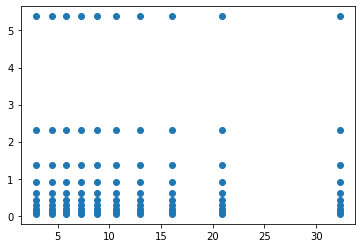

In [305]:
plt.scatter(a,b)

In [236]:
sig1 = 4
sig2 = 2

c = sig1*xv + sig2*yv 
c[1:,:]

array([[10, 12],
       [14, 16]])

In [231]:
np.diff(yv)

array([[1],
       [1],
       [1]])

In [238]:
# define NORM and YPRED_FUN
npdf = np.array([10,10])

if npdf[0] == npdf[1]:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[0])*np.pi)+1)/2)
    NORM = stats.norm.ppf(q)
    NORM_nas = torch.tensor(NORM)
    NORM_mat = NORM_nas
else:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[0])*np.pi)+1)/2)
    print(q)
    NORM_nas = torch.tensor(stats.norm.ppf(q))
    n = np.arange(npdf[1])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[1])*np.pi)+1)/2)
    print(q)
    NORM_mat = torch.tensor(stats.norm.ppf(q))
    
lnfactorial = torch.special.gammaln(torch.arange(1003))

YPRED_FUN = lambda p, y, npdf, w, hyp, l_out: get_ypred_at_RT_affine(p=p,
                                            y=y,npdf=npdf,w=w,hyp=hyp,l_out=l_out,
                                               grid_method='logn',quantiles='PRESET')

Load in how many training and testing files you want. Get data now also needs set size

In [95]:
train_list, test_list = tr.get_data(set_size = 256,
                                    number_of_training_files=1,
                                 number_of_testing_files=1,total_files=3,file_path=path)

In [96]:
import train_2D_rt_v2 as tr2

In [118]:
import importlib
importlib.reload(tr2)

<module 'train_2D_rt_v2' from '/home/mcarilli/CME/2D_CME/learning_environment/train_2D_rt_v2.py'>

In [130]:
l_out = torch.tensor([0.5923, 0.5799, 0.6740, 0.4985])
A,B,C,D = l_out


A*NORM_mat + B*NORM_nas

tensor([-2.9341, -1.8787, -1.2329, -0.7077, -0.2313,  0.2313,  0.7077,  1.2329,
         1.8787,  2.9341], dtype=torch.float64)

In [215]:
a = torch.ones(10)
b = torch.ones(20)

torch.Size([10, 20])

In [303]:
t1 = time.time()
e,b,t,model = tr2.train_MLP(train_list[0:1],test_list[0:1],num_epochs=1,
                           npdf=[10,10],batchsize=10,get_ypred_at_RT=get_ypred_at_RT_affine,
                           metric='kld',learning_rate=1e-3,MLP=1)
t2 = time.time()

print(t2-t1)



# IF YOU WANT TO SAVE
#path1 = 'DEFINE/PATH/TO/STORE'
#np.save(path1+'e_t',[e,t])
#torch.save(model.state_dict(),'./test_MODEL')

Epoch Number: 0
tensor([[ 2.8896,  2.8896,  2.8896,  2.8896,  2.8896,  2.8896,  2.8896,  2.8896,
          2.8896,  2.8896],
        [ 4.4610,  4.4610,  4.4610,  4.4610,  4.4610,  4.4610,  4.4610,  4.4610,
          4.4610,  4.4610],
        [ 5.8187,  5.8187,  5.8187,  5.8187,  5.8187,  5.8187,  5.8187,  5.8187,
          5.8187,  5.8187],
        [ 7.2223,  7.2223,  7.2223,  7.2223,  7.2223,  7.2223,  7.2223,  7.2223,
          7.2223,  7.2223],
        [ 8.7863,  8.7863,  8.7863,  8.7863,  8.7863,  8.7863,  8.7863,  8.7863,
          8.7863,  8.7863],
        [10.6286, 10.6286, 10.6286, 10.6286, 10.6286, 10.6286, 10.6286, 10.6286,
         10.6286, 10.6286],
        [12.9302, 12.9302, 12.9302, 12.9302, 12.9302, 12.9302, 12.9302, 12.9302,
         12.9302, 12.9302],
        [16.0492, 16.0492, 16.0492, 16.0492, 16.0492, 16.0492, 16.0492, 16.0492,
         16.0492, 16.0492],
        [20.9342, 20.9342, 20.9342, 20.9342, 20.9342, 20.9342, 20.9342, 20.9342,
         20.9342, 20.9342],
   

In [81]:
torch.save(model.state_dict(),'./quadvec_models/03172022_20npdf_256params_20e_hyp_MODEL')

In [262]:
e,t,b

(array([0.95525426, 0.8607049 , 0.77342546, 0.69760478, 0.63706481]),
 [0.8607049062848091,
  0.7734254553914071,
  0.6976047962903976,
  0.6370647728443146,
  0.5927150920033455],
 array([0.95525426, 0.8607049 , 0.77342546, 0.69760478, 0.63706481]))

# Plotting!


If you have already stored your model, load it in!

In [128]:
# pre-loaded model

path = './dir_03032022/'
npdf = [10,11]
model = tr.my_MLP1(3,npdf[0]*npdf[1])
model.load_state_dict(torch.load(path+'MODEL_kld'))
model.eval()
#array = np.load(path+ 'mselog.npy',allow_pickle=True)
#e = array[0]
#t = array[1]

my_MLP1(
  (input): Linear(in_features=3, out_features=256, bias=True)
  (hidden1): Linear(in_features=256, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=110, bias=True)
  (softmax): Softmax(dim=1)
)

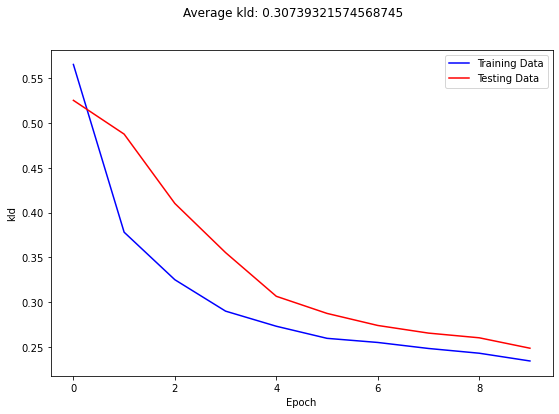

In [284]:
metric = 'kld'

tt.plot_training(e,t,metric)

## Metric Histogram

In [280]:


# i know the function still says test_klds, but now it calculates whatever metric you give it

metrics, metric_mean = tr2.calculate_test_metrics(test_list=train_list[0:12],npdf= [10,10],
                                        model=model,get_ypred_at_RT=get_ypred_at_RT_affine,
                                             metric = metric)

In [103]:
metrics

array([0.41969925, 0.3417404 , 0.08398814, 0.18781659, 0.54304856,
       1.3641516 , 0.19310889, 0.13790148, 0.07387512, 1.0617125 ,
       0.08024925, 0.06544714])

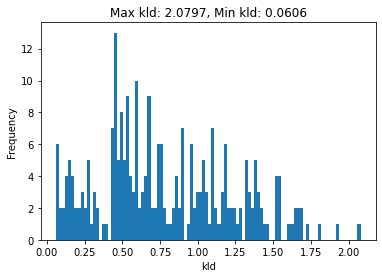

In [98]:
tt.plot_histogram(metrics,bins=10,metric=metric)

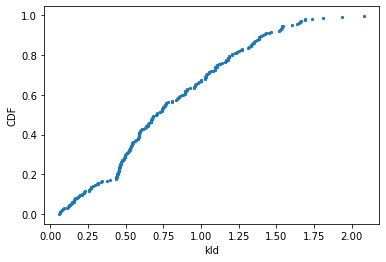

In [99]:
tt.plot_CDF(metrics,metric)

## Plot Param Quantiles

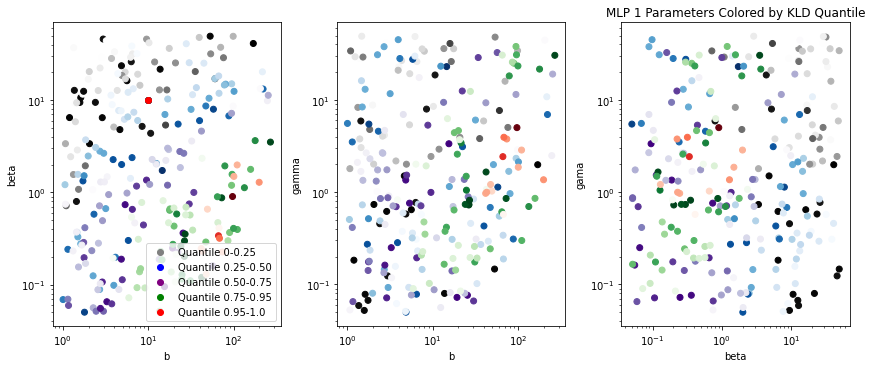

In [100]:
tt.plot_param_quantiles(metrics,train_list,model)

## Plot PMFs

In [16]:
import tools_2D_rt_v2 as tt2

In [45]:
importlib.reload(tt2)

<module 'tools_2D_rt_v2' from '/home/mcarilli/CME/2D_CME/learning_environment/tools_2D_rt_v2.py'>

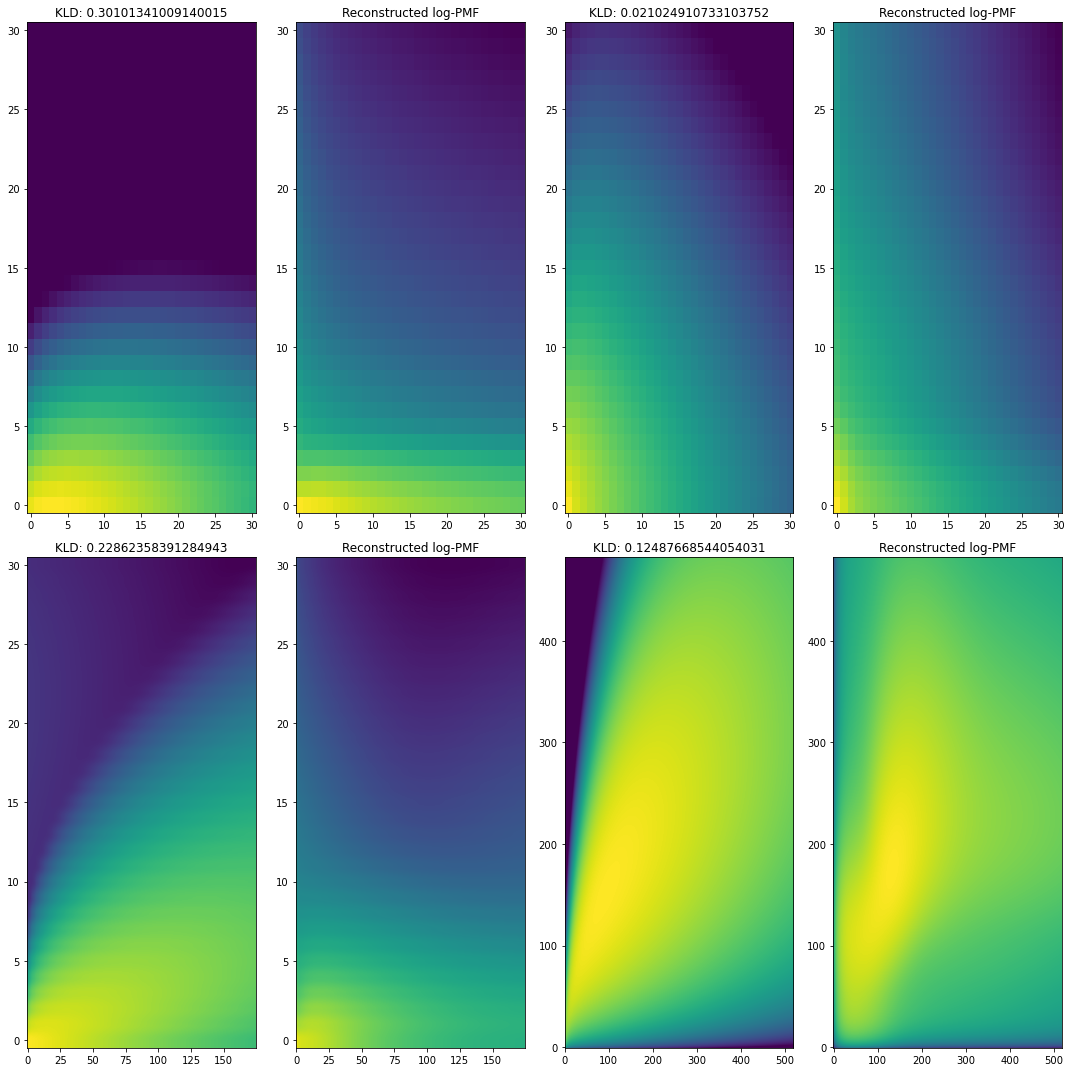

In [288]:
tt2.plot_PMF_grid(file_list=train_list[0:10],npdf=[10,10],nrows=2,
                 ncols=2,model=model,get_ypred_at_RT=get_ypred_at_RT_affine)

3.618108166847378e-06 :  3.618108166847378e-06


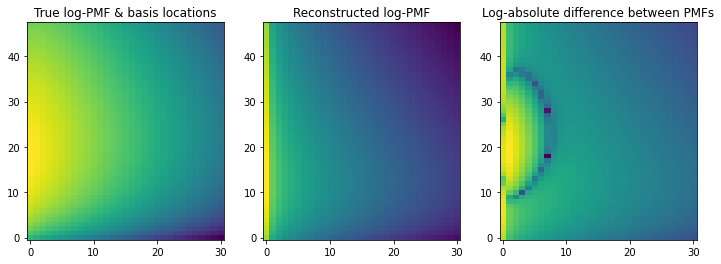

In [86]:
p_num = 200

params[p_num]

tt.plot_PMF(params[p_num:p_num+1],[ys[p_num]],[5,6],model,get_ypred_at_RT,metric)